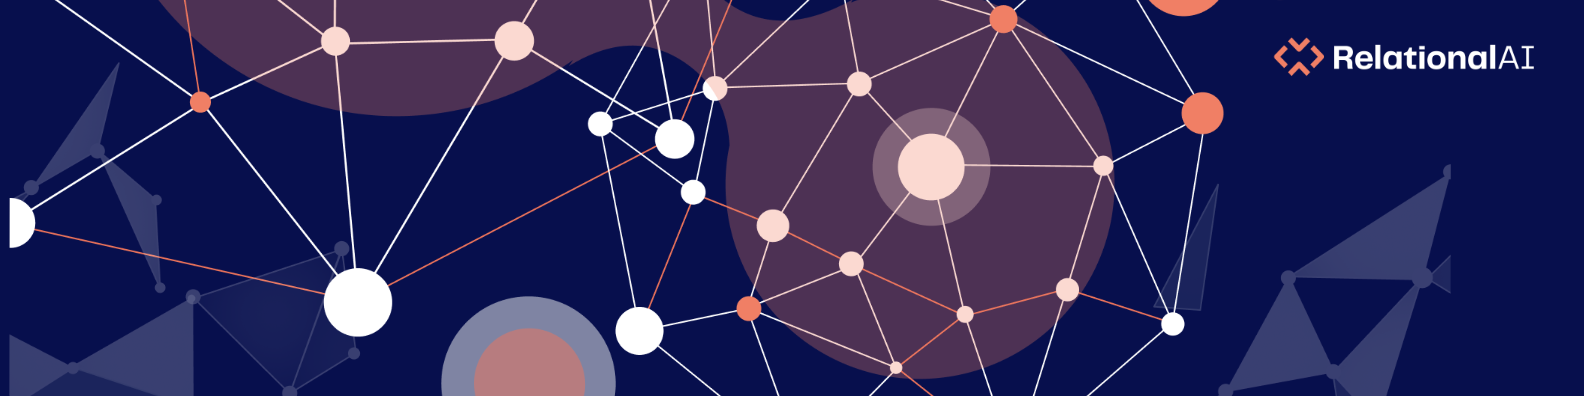

# Infomap

The `infomap` function returns a `community`, to which a node belongs, which is determined using [Infomap algorithm](https://www.mapequation.org/assets/publications/EurPhysJ2010Rosvall.pdf).

In the analysis of social networks, for instance, it can often be useful to identify subgroups of connected people. These subgroups can be detected by using an algorithm such as Infomap.

Let us look at a very small example social graph and use Infomap to identify which people belong to which subgroups.

Our graph will model a social network in which people are connected based on common hobbies. We will first apply the algorithm to unweighted undirected graph, then add the number of common hobbies as weights to the edges and look at the difference in the results.

First, we need to import the `relationalai` library and define our model, which we call `MyInfomapGraph`. We also create two types called `Person` and `HobbyLink`.

In [ ]:
%pip install relationalai

In [2]:
import relationalai as rai
from relationalai.std import alias
from relationalai.std.graphs import Graph

model = rai.Model("MyInfomapGraph")

# Model will hold these types:

# Represent nodes
Person = model.Type("Person")

# Represent connections between nodes
HobbyLink = model.Type("HobbyLink")

## Let's add some data to our model
We first create a dictionary of people names, who have common hobbies, and how many hobbies they share. Then we iterate over the dictionary to create objects of type `Person` with a `name` property. We also create `HobbyLink` objects with `common_count` property, representing connection between two people. We will use it to create weighted edges between nodes in our graph.

In [3]:
data = {
    ("Mary", "Bob"): 5,
    ("Mary", "Jessy"): 2,
    ("Mary", "Erica"): 1,
    ("Mary", "Tom"): 1,
    ("Mary", "Chris"): 1,
    ("Bob", "Chris"): 3,
    ("Bob", "Frank"): 1,
    ("Jessy", "Erica"): 5,
    ("Erica", "Tom"): 5,
    ("Tom", "Jessy"): 5,
    ("Frank", "Anna"): 5,
    ("Frank", "Mark"): 5,
    ("Frank", "Peter"): 2,
    ("Anna", "Peter"): 1,
    ("Anna", "Mark"): 5,
    ("Peter", "Mark"): 1,
}

with model.rule(dynamic = True):
    for (fellows, common_hobbies) in data.items():
        name, fellow_name = fellows
        person = Person.add(name = name)
        fellow = Person.add(name = fellow_name)
        HobbyLink.add(person = person, fellow = fellow).set(count_common = common_hobbies)


## Creating the graph
Let's start by creating a `graph` with `Node` and `Edge` collections. We add all `Person` instances as nodes, and assign the `name` property so that we can use them in our queries and for visualization purposes. The `HobbyLink` instances are then used to form the `edges` in our graph.

In [4]:
# Create graph
graph = Graph(model, undirected = True)
Node, Edge = graph.Node, graph.Edge

# add all Person instances as Nodes and assign `name` property (for displaying)
Node.extend(Person, name = Person.name)

# add all HobbyLink instances as Edges from `person` to `fellow` Nodes
with model.rule():
    l = HobbyLink()
    Edge.add(l.person, l.fellow)

## Running the algorithm
Let's add a rule that calculates for every node of the graph the community that it `belongs_to`. To derive this value for each node using the infomap algorithm, we can simply use `Graph(model).compute.infomap()`.

In [5]:
# run infomap algorithm on the Graph,
# for every Person node assign the community it belongs to
with model.rule():
    p = Person()
    community = graph.compute.infomap(p)
    p.set(belongs_to = community)
    Node(p).set(community = community)

## Querying the Graph
Graph Nodes, Edges and their properties are queried using `model.query()` context and `graph.Node()` or `graph.Edge()` types.

Alternatively, the entire graph representation can be fetched using `Graph(model).fetch()`. This returns a dictionary with two keys, `nodes` and `edges`, that represents the entire graph. 

In [6]:
# query all Edges with `name` and `community` properties of the Nodes they connect
with model.query() as select:
    e = Edge()
    n1 = Node(e.from_)
    n2 = Node(e.to)
    response = select(alias(n1.name, 'from'), alias(n1.community, 'community (from)'), alias(n2.name, 'to'), alias(n2.community, 'community (to)'))

response

# fetch the entire graph dictionary (not recommended to be used for large graphs)
# graph_dict = graph.fetch()

### How many communities were found? And to which communities do people belong?

In [7]:
# For each Person, fetch the name and the community they belong to
with model.query() as select:
    p = Person()
    response = select(p.name, p.belongs_to)

response

In [8]:
# Group the response from the above query by the belongs_to property to separate the communities
communities = response.results.groupby("belongs_to").name.apply(list)

# Print the number of communities
count_communities = len(communities)
print(f"Number of communities: {count_communities}")

# Print communities and people that belong to them
for i, c in enumerate(communities):
    print(f"Community N{i+1}: {c}")

Number of communities: 2
Community N1: ['Anna', 'Frank', 'Mark', 'Peter']
Community N2: ['Bob', 'Chris', 'Erica', 'Jessy', 'Mary', 'Tom']


### Let's find out who is in the same community as Anna

In [9]:
person_name = "Anna"

with model.query() as select:
    p1 = Person(name = person_name)
    p2 = Person()
    # We want to skip the person itself
    p1 != p2
    p1.belongs_to == p2.belongs_to
    response = select(p2.name)

response

## Visualizing the results
Let's visualize our graph, to better understand the results. We use `Graph(model).visualize()` to visualize our graph. We define a color for each of the communities.

In [10]:
graph.visualize(three = False, style = {
    "node": {
        "color": lambda n : ['blue', 'pink'][list(communities.keys()).index(n['community']) % 2],
        "label": lambda n : n['name'],
        "hover": lambda n: n['community'],
        "size": 30
    },
    "edge": {
        "color": "green"
    }
}).display(inline = True)

## Adding weights to the graph edges

As a final step, let's see how adding weights to the graph edges affects the result of the algorithm.
Let's create a new graph with the same Nodes and Edges, but now using `HobbyLink.count_common` property as a weight of an edge.

In [11]:
# Create weighted graph
weighted_graph = Graph(model, undirected = True, weighted = True)

# add all same Person instances as Nodes and assign `name` property
weighted_graph.Node.extend(Person, name = Person.name)

# add all HobbyLink instances as Edges from `person` to `fellow` Nodes with weight property
with model.rule():
    l = HobbyLink()
    weighted_graph.Edge.add(l.person, l.fellow, weight = l.count_common)

# run infomap algorithm on the new Graph
with model.rule():
    n = weighted_graph.Node()
    n.set(community = weighted_graph.compute.infomap(n))

### How many communities were found now?

In [12]:
# query weighted graph nodes names and communities they were assigned to
with model.query() as select:
    n = weighted_graph.Node()
    response = select(n.name, n.community)

# group names by community_id
communities = response.results.groupby("community").name.apply(list)

# print communities and names of people that belong to them
for i, c in enumerate(communities):
    print(f"Community N{i+1}: {c}")

Community N1: ['Anna', 'Frank', 'Mark', 'Peter']
Community N2: ['Erica', 'Jessy', 'Tom']
Community N3: ['Bob', 'Chris', 'Mary']


### Visualizing the weighted graph

Let's make the size of the Edges proportional to the weight. Additionally, we'll define more colors since we now have more communities.

In [13]:
weighted_graph.visualize(three = False, style = {
    "node": {
        "color": lambda n : ['blue', 'pink', 'yellow'][list(communities.keys()).index(n['community']) % 3],
        "label": lambda n : n['name'],
        "hover": lambda n: n['community'],
        "size": 30
    },
    "edge": {
        "color": "green",
        "size": lambda e: e['weight']
    }
}).display(inline = True)